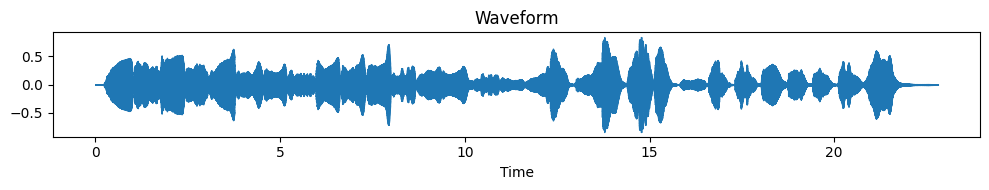

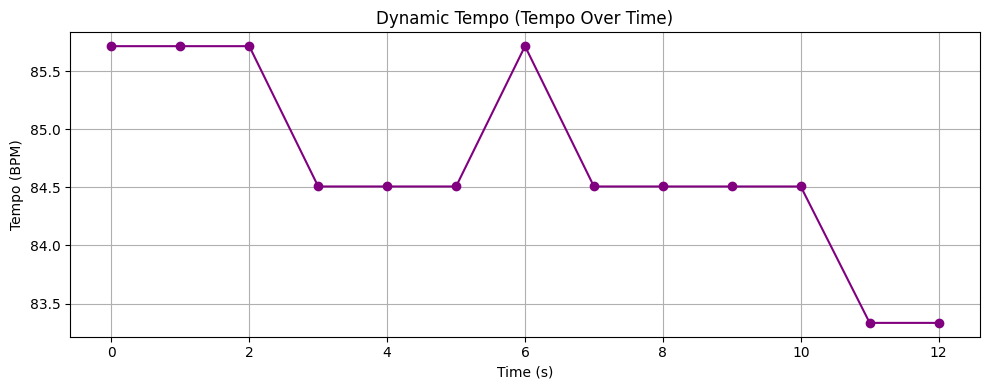

In [30]:
# Step 1: Imports
import numpy as np
import matplotlib.pyplot as plt
import madmom
from madmom.audio.signal import SignalProcessor
from madmom.features.beats import RNNBeatProcessor, DBNBeatTrackingProcessor
from madmom.features.tempo import TempoEstimationProcessor
import librosa.display
import os

ffmpeg_path = "/usr/local/bin"
os.environ["PATH"] += os.pathsep + ffmpeg_path

# Step 2: Load audio file
audio_path = 'violin_recording.wav'  # Replace with your audio file path
signal, sr = madmom.io.audio.load_wave_file(audio_path)

signal = SignalProcessor(num_channels=1)(audio_path)

# Optional: show waveform
y, sr = librosa.load(audio_path, sr=sr)
plt.figure(figsize=(10, 2))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform")
plt.tight_layout()
plt.show()

# Step 3: Beat activation function (from RNN)
beat_act = RNNBeatProcessor()(signal)

# Step 4: Sliding window tempo estimation
# Define window and hop in seconds
window_size = 10.0  # e.g. 10-second window
hop_size = 1.0      # e.g. 1-second hop

# Step 5: Process activations in windows
frame_rate = 100  # RNN output frame rate = 100 Hz
window_frames = int(window_size * frame_rate)
hop_frames = int(hop_size * frame_rate)

tempos = []
times = []

tempo_estimator = TempoEstimationProcessor(fps=frame_rate)

for start in range(0, len(beat_act) - window_frames, hop_frames):
    end = start + window_frames
    window_act = beat_act[start:end]
    tempo_info = tempo_estimator(window_act)
    # Get tempo in BPM (first candidate)
    bpm = tempo_info[0][0]
    tempos.append(bpm)
    times.append(start / frame_rate)

# Step 6: Plot dynamic tempo over time
plt.figure(figsize=(10, 4))
plt.plot(times, tempos, marker='o', color='purple')
plt.title("Dynamic Tempo (Tempo Over Time)")
plt.xlabel("Time (s)")
plt.ylabel("Tempo (BPM)")
plt.grid(True)
plt.tight_layout()
plt.show()


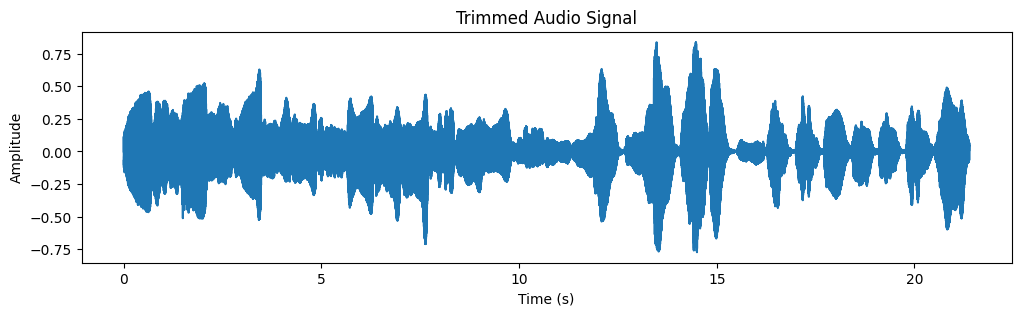

In [31]:
# Cell 1: Load and preprocess audio
import librosa
import numpy as np
import matplotlib.pyplot as plt

# Set path to your audio file
audio_path = "violin_recording.wav"  # Replace with your file path

# Load the audio
y, sr = librosa.load(audio_path, sr=None)

# Remove silence (top_db can be adjusted for sensitivity)
y_trimmed, index = librosa.effects.trim(y, top_db=20)

# Visualize
plt.figure(figsize=(12, 3))
plt.title("Trimmed Audio Signal")
plt.plot(np.linspace(0, len(y_trimmed)/sr, len(y_trimmed)), y_trimmed)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import essentia.standard as es
from madmom.features.beats import RNNBeatProcessor
from madmom.features.tempo import TempoEstimationProcessor

# --- Setup shared time axis ---
window_size = 10.0
hop_size = 1.0
frame_rate = 100
window_frames = int(window_size * frame_rate)
hop_frames = int(hop_size * frame_rate)

shared_times = []
for start in range(0, len(signal) - window_frames, hop_frames):
    shared_times.append(start / frame_rate)

# ---------------------------
# METHOD 1: MADMOM
# ---------------------------
beat_act = RNNBeatProcessor()(signal)
madmom_tempos = []
tempo_estimator = TempoEstimationProcessor(fps=frame_rate)

for start in range(0, len(beat_act) - window_frames, hop_frames):
    end = start + window_frames
    window_act = beat_act[start:end]
    bpm = tempo_estimator(window_act)[0][0]
    madmom_tempos.append(bpm)

# ---------------------------
# METHOD 2: ESSENTIA RhythmExtractor2013
# ---------------------------
audio_ess = es.MonoLoader(filename=audio_path)()
rhythm_extractor = es.RhythmExtractor2013(method="multifeature")
ess_bpm, ess_beats, _, _, _ = rhythm_extractor(audio_ess)

ess_tempos = []
for t in shared_times:
    window_beats = ess_beats[(ess_beats >= t) & (ess_beats < t + window_size)]
    if len(window_beats) > 1:
        mean_interval = np.mean(np.diff(window_beats))
        bpm = 60.0 / mean_interval
        ess_tempos.append(bpm)
    else:
        ess_tempos.append(np.nan)

# ---------------------------
# METHOD 3: ESSENTIA TempoCNN
# ---------------------------
# Downsample for CNN
audio_11khz = es.MonoLoader(filename=audio_path, sampleRate=11025)()
global_bpm, local_bpm, local_probs = es.TempoCNN(graphFilename='./models/deeptemp-k16-3.pb')(audio_11khz)

# Convert local_bpm to values per frame (86 fps by default)
cnn_frame_rate = 86
cnn_times = np.arange(len(local_bpm)) / cnn_frame_rate

# Interpolate CNN tempo to shared_times
cnn_tempos_interp = np.interp(shared_times, cnn_times, local_bpm)

# ---------------------------
# METHOD 4: LIBROSA
# ---------------------------
librosa_tempos = []
y_trimmed, _ = librosa.effects.trim(y)

for t in shared_times:
    start_sample = int(t * sr)
    end_sample = int((t + window_size) * sr)
    window_y = y_trimmed[start_sample:end_sample]
    if len(window_y) > 0:
        bpm = librosa.beat.tempo(y=window_y, sr=sr, aggregate=None)
        librosa_tempos.append(float(bpm[0]) if bpm is not None else np.nan)
    else:
        librosa_tempos.append(np.nan)

# ---------------------------
# PLOT ALL TEMPO TRACKS
# ---------------------------
plt.figure(figsize=(14, 5))

plt.plot(shared_times, madmom_tempos, label='Madmom', color='purple')
plt.plot(shared_times, ess_tempos, label='Essentia RhythmExtractor2013', color='green')
plt.plot(shared_times, cnn_tempos_interp, label='Essentia TempoCNN', color='blue')
plt.plot(shared_times, librosa_tempos, label='Librosa', color='red')

plt.title("Dynamic Tempo Comparison (BPM over Time)")
plt.xlabel("Time (s)")
plt.ylabel("Tempo (BPM)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


2025-06-02 15:09:27.272822: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.13.1


AttributeError: module 'essentia.standard' has no attribute 'TempoCNN'

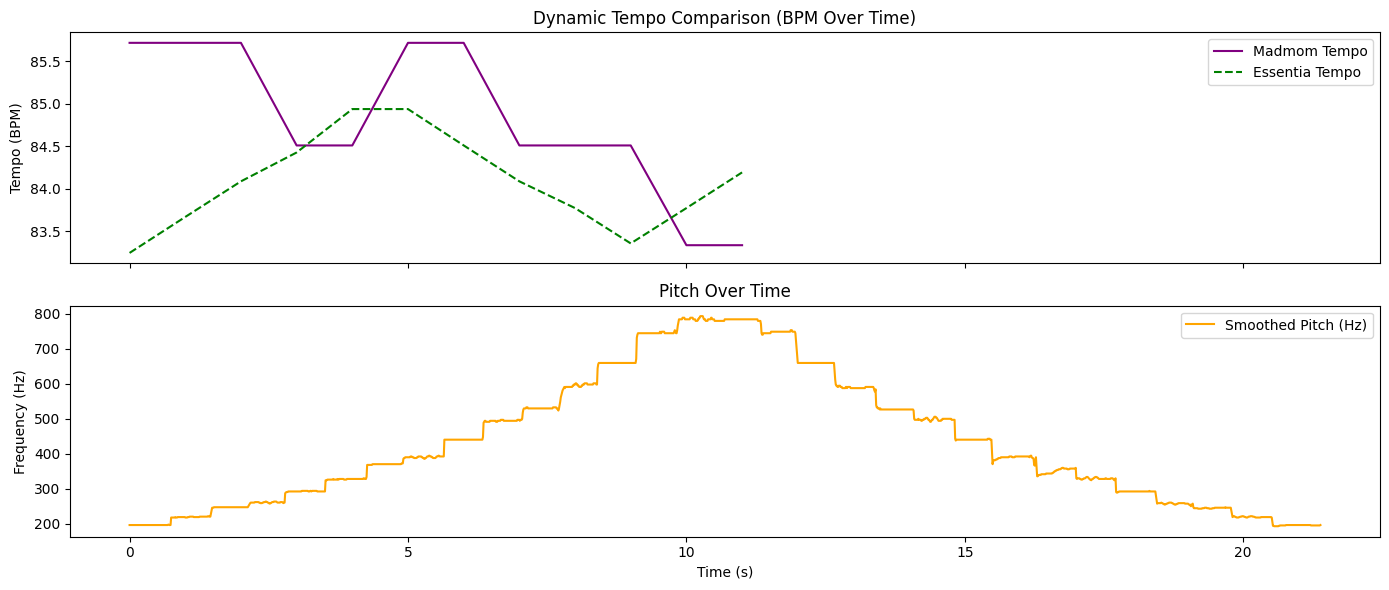

In [40]:
# --- MADMOM dynamic tempo estimation ---
from madmom.features.beats import RNNBeatProcessor
from madmom.features.tempo import TempoEstimationProcessor

# Step 1: Beat activation (100 fps)
beat_act = RNNBeatProcessor()(signal)

# Step 2: Sliding window tempo estimation
window_size = 10.0
hop_size = 1.0
frame_rate = 100
window_frames = int(window_size * frame_rate)
hop_frames = int(hop_size * frame_rate)

madmom_tempos = []
shared_times = []

tempo_estimator = TempoEstimationProcessor(fps=frame_rate)
for start in range(0, len(beat_act) - window_frames, hop_frames):
    end = start + window_frames
    window_act = beat_act[start:end]
    tempo_info = tempo_estimator(window_act)
    bpm = tempo_info[0][0]
    madmom_tempos.append(bpm)
    shared_times.append(start / frame_rate)  # seconds

# --- ESSENTIA dynamic tempo estimation from beat intervals ---
import essentia.standard as es

# Load audio with Essentia
audio = es.MonoLoader(filename=audio_path)()

# Beat positions from RhythmExtractor2013
rhythm_extractor = es.RhythmExtractor2013(method="multifeature")
ess_bpm, ess_beats, _, _, _ = rhythm_extractor(audio)

# Calculate local tempo using beat intervals over time windows
ess_tempos = []
for time in shared_times:
    window_start = time
    window_end = time + window_size
    window_beats = ess_beats[(ess_beats >= window_start) & (ess_beats < window_end)]

    if len(window_beats) > 1:
        intervals = np.diff(window_beats)
        mean_interval = np.mean(intervals)
        bpm = 60.0 / mean_interval
        ess_tempos.append(bpm)
    else:
        ess_tempos.append(np.nan)  # Not enough beats to estimate tempo

# --- Pitch estimation and smoothing ---
f0, voiced_flag, _ = librosa.pyin(
    y_trimmed,
    fmin=librosa.note_to_hz('C2'),
    fmax=librosa.note_to_hz('C7'),
    sr=sr,
    hop_length=512
)
pitch_times = librosa.frames_to_time(np.arange(len(f0)), sr=sr, hop_length=512)

f0_smooth = np.copy(f0)
nans = np.isnan(f0_smooth)
if np.any(~nans):
    f0_smooth[nans] = np.interp(np.flatnonzero(nans), np.flatnonzero(~nans), f0_smooth[~nans])

# --- Plot Tempo Comparison and Pitch ---
fig, axs = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

# Tempo (MADMOM vs. ESSENTIA)
axs[0].plot(shared_times, madmom_tempos, label="Madmom Tempo", color='purple')
axs[0].plot(shared_times, ess_tempos, label="Essentia Tempo", color='green', linestyle='--')
axs[0].set_title("Dynamic Tempo Comparison (BPM Over Time)")
axs[0].set_ylabel("Tempo (BPM)")
axs[0].legend()

# Pitch
axs[1].plot(pitch_times, f0_smooth, label="Smoothed Pitch (Hz)", color='orange')
axs[1].set_title("Pitch Over Time")
axs[1].set_ylabel("Frequency (Hz)")
axs[1].set_xlabel("Time (s)")
axs[1].legend()

plt.tight_layout()
plt.show()


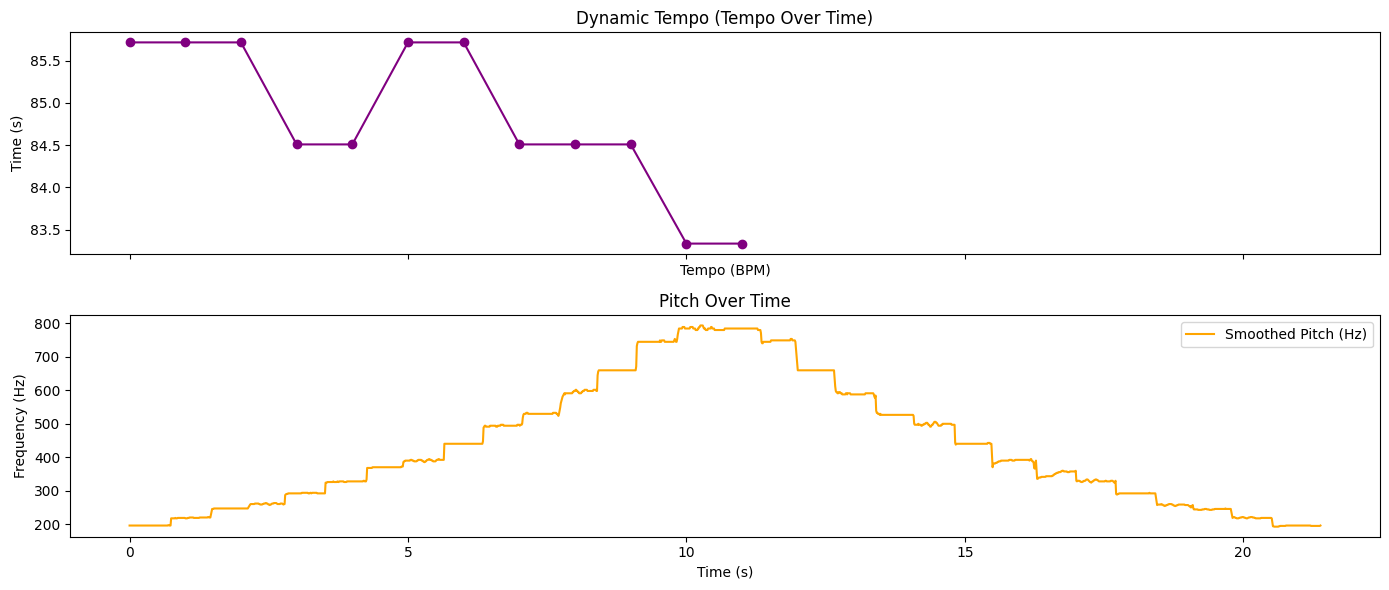

In [ ]:
# Cell 2: Tempo in BPM over time + Smooth pitch over time
from madmom.audio.signal import Signal
from madmom.features.tempo import TempoEstimationProcessor

# Convert audio to mono signal for madmom
beat_act = RNNBeatProcessor()(signal)

# Step 4: Sliding window tempo estimation
# Define window and hop in seconds
window_size = 10.0  # e.g. 10-second window
hop_size = 1.0      # e.g. 1-second hop

# Step 5: Process activations in windows
frame_rate = 100  # RNN output frame rate = 100 Hz
window_frames = int(window_size * frame_rate)
hop_frames = int(hop_size * frame_rate)

tempos = []
times = []

tempo_estimator = TempoEstimationProcessor(fps=frame_rate)

for start in range(0, len(beat_act) - window_frames, hop_frames):
    end = start + window_frames
    window_act = beat_act[start:end]
    tempo_info = tempo_estimator(window_act)
    # Get tempo in BPM (first candidate)
    bpm = tempo_info[0][0]
    tempos.append(bpm)
    times.append(start / frame_rate)

# --- Pitch (smoothed with interpolation) ---
f0, voiced_flag, _ = librosa.pyin(
    y_trimmed,
    fmin=librosa.note_to_hz('C2'),
    fmax=librosa.note_to_hz('C7'),
    sr=sr,
    hop_length=512
)

pitch_times = librosa.frames_to_time(np.arange(len(f0)), sr=sr, hop_length=512)

# Interpolate NaNs to smooth pitch
f0_smooth = np.copy(f0)
nans = np.isnan(f0_smooth)
if np.any(~nans):  # Ensure we have at least one voiced frame
    f0_smooth[nans] = np.interp(np.flatnonzero(nans), np.flatnonzero(~nans), f0_smooth[~nans])

# --- Plot ---
fig, axs = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

# Step 6: Plot dynamic tempo over time
axs[0].plot(times, tempos, marker='o', color='purple')
axs[0].set_title("Dynamic Tempo (Tempo Over Time)")
axs[0].set_ylabel("Time (s)")
axs[0].set_xlabel("Tempo (BPM)")

axs[1].plot(pitch_times, f0_smooth, color='orange')
axs[1].set_title("Pitch Over Time")
axs[1].set_ylabel("Frequency (Hz)")
axs[1].set_xlabel("Time (s)")

plt.tight_layout()
plt.show()
